In [1]:
import numpy as np
from ase.io import read
import ipywidgets as widgets
import matplotlib.pyplot as plt

from abtem.visualize.widgets import quick_sliders
from abtem.special_structures import graphene_bilayer
from abtem.structures import orthogonalize_cell
from abtem import *

from abtem.visualize.interactive import Canvas, MeasurementArtist2d
from abtem.visualize.interactive.utils import throttle
from abtem.visualize.interactive.tools import SelectPositionTool, BoxZoomTool, PanZoomTool
from abtem.measure import block_zeroth_order_spot

# Interactive CBED

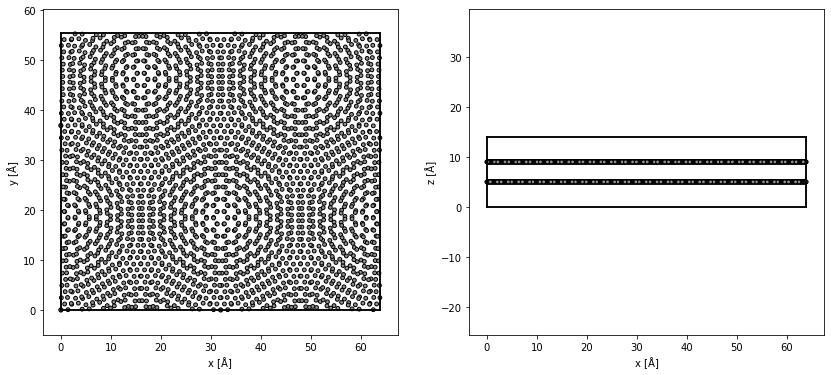

In [2]:
atoms = graphene_bilayer(8, d=5)
atoms = orthogonalize_cell(atoms)

atoms *= (2,1,1)

atoms.center(axis=2,vacuum=5)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))
show_atoms(atoms,plane='xy',ax=ax1)
show_atoms(atoms,plane='xz',ax=ax2);

In [3]:
device = 'gpu'

S = SMatrix(expansion_cutoff=14,
            interpolation=1, 
            energy=60e3,
            gpts=512,
            semiangle_cutoff=10, 
            device=device,
            storage=device)

potential = Potential(atoms, precalculate=False, device=device, projection='infinite', parametrization='kirkland')
S = S.multislice(potential, pbar=False)
S = S.downsample(max_angle = 90)

Select the position tool to drag the probe on the left panel. If you don't have a fast GPU you may need to increase throttling or decrease system size.

In [4]:
throttling = 0.01

canvas1 = Canvas()
canvas2 = Canvas()

probe_artist = MeasurementArtist2d()
diffraction_artist = MeasurementArtist2d()

canvas1.artists = {'artist': probe_artist}
canvas2.artists = {'artist': diffraction_artist}

position_tool = SelectPositionTool(marker=False)
canvas1.tools = {'Position' : position_tool}
canvas2.tools = {'Zoom': BoxZoomTool(), 'Pan':PanZoomTool()}
block_direct_button = widgets.ToggleButton(description='Block direct beam')

def update(*args):
    wave = S.collapse(position_tool.position)    
    measurement1 = wave.intensity()
    measurement2 = wave.diffraction_pattern()
    if block_direct_button.value:
        measurement2 = block_zeroth_order_spot(measurement2, S.ctf.semiangle_cutoff)

    probe_artist.measurement = measurement1[0]
    diffraction_artist.measurement = measurement2[0]


throttled_update = throttle(throttling)(update)

    
sliders = quick_sliders(S.ctf, 
                        semiangle_cutoff=(2, 14, .5),
                        defocus=(-10000,10000,10),
                        Cs=(-1e8,1e8,1e3),
                        astigmatism=(-1000,1000,10),
                        astigmatism_angle=(0,2*np.pi,.1)
                        )

S.ctf.observe(throttled_update)
position_tool.observe(throttled_update, 'position')
block_direct_button.observe(throttled_update)

update()
canvas1.adjust_limits_to_artists()
canvas1.adjust_labels_to_artists()
canvas2.adjust_limits_to_artists()
canvas2.adjust_labels_to_artists()

update()
widgets.VBox([widgets.HBox([widgets.VBox([canvas1.figure, canvas1.toolbar, block_direct_button]  + sliders), 
                            widgets.VBox([canvas2.figure, diffraction_artist.image_artist.color_scheme_picker])])])